In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import numpy.random as r
import matplotlib.pyplot as plt
import pickle

In [0]:
def f(x):
    return 1 / (1 + np.exp(-x))
    
def f_deriv(x):
    return f(x) * (1 - f(x))

In [0]:
def setup_and_init_weights(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1]))
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

In [0]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

In [0]:
def feed_forward(x, W, b):
    h = {1: x}
    z = {}
    for l in range(1, len(W) + 1):
        # if its the first layer, then the input into the weights is x, otherwise,
        # it is the output from the last layer
        if l == 1:
            node_in = x
        else:
            node_in = h[l]
        z[l+1] = W[l].dot(node_in) + b[l] # z^(l+1) = W^(l)*h^(l) + b^(l)
        h[l+1] = f(z[l+1]) # h^(l) = f(z^(l))
    return h, z

In [0]:
def calculate_out_layer_delta(y, h_out, z_out):
    # delta^(nl) = -(y_i - h_i^(nl)) * f'(z_i^(nl))
    return -(y-h_out) * f_deriv(z_out)


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

In [0]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    m = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(len(y)):
            delta = {}
            # perform the feed forward pass and return the stored h and z values | выполнить проход прямого распостранения и вернуть сохраненные значения h и z
            # to be used in the gradient descent step | которые будут использоваться на этапе градиентного спуска
            h, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors | цикл от nl(длина сети) до 1, обратное распостранение ошибки
            for l in range(len(nn_structure), 0, -1): # [3, 2, 1]
                if l == len(nn_structure): # если ето виходной слой, то
                    delta[l] = calculate_out_layer_delta(y[i], h[l], z[l]) # оценочная функция для выходного слоя
                    avg_cost += np.linalg.norm((y[i]-h[l])) # norm of the matrix
                else: 
                    if l > 1: # если скрый слой
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l]) # оценочная функция для скрытого слоя
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(h^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis])) # сумма частных производных функции оценки каждого экземпляра
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1): # процесс градиентного спуска
            W[l] += -alpha * (1.0/m * tri_W[l])
            b[l] += -alpha * (1.0/m * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/m * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func

In [0]:
def predict_y(W, b, X, n_layers):
    m = X.shape[0]
    y = np.zeros((m,))
    for i in range(m):
        h, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(h[n_layers])
    return y

In [0]:
pickle_in = open("/content/tcp.pickle", "rb")
transw = pickle.load(pickle_in)

X_scale = StandardScaler()
X = X_scale.fit_transform(np.array(transw[0])) # поместить в первую часть масива обучающие данные [[T, L, averV, firstV, firstL, maxV, clickT, nDev], ...]
y = np.array(transw[1]) # а во вторую ответы [1, 0, 1, ...]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_train, X_test, y_train, y_test


(array([[-7.50006181e-01,  5.42287248e-01,  1.78240202e+00,
          4.68136000e-01,  5.44694055e-01, -3.58469431e-01,
         -3.32302193e-01, -6.65056392e-01],
        [ 1.68819888e+00, -2.10557753e-01, -1.04770659e+00,
         -8.04618499e-01, -3.35519297e-01, -3.74305988e-01,
         -1.36422832e-01,  1.47434542e+00],
        [ 6.35836823e-01, -1.78285808e-01, -7.20889505e-01,
         -1.10914228e-01, -2.21118527e-01,  1.42222373e-01,
         -4.97004400e-01, -3.26193141e-01],
        [-4.19084937e-01,  1.33598078e-01,  4.43800121e-01,
         -2.77502199e-01,  3.08517873e-02,  5.67470854e-01,
         -3.36786396e-01,  1.03301037e+00],
        [-5.91639352e-01, -1.17525355e+00, -1.14264327e+00,
         -5.98567167e-01, -1.10313081e+00, -3.78677435e-01,
         -4.97865541e-01, -1.11579171e+00],
        [-5.19311745e-01, -2.13846131e-01,  1.35803155e-01,
          1.15263320e-01, -3.35491101e-01, -3.71348488e-01,
          8.61685087e-01, -1.00375437e+00],
        [-1.1165

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


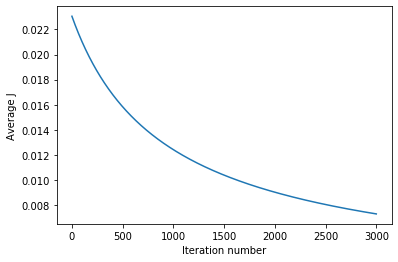

Prediction accuracy is 0.0%


In [0]:
# setup the NN structure
nn_structure = [8, 32, 1]
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_train)
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))